# Converting the PDF files into vector database

# 1. Initial setup

## 1.1 Imports
This setup includes loading environment variables from a `.env` file, setting the required environment variables, and importing the necessary modules for further processing. It ensures that the code has access to the required APIs and functions for the subsequent tasks.

In [2]:
# Initial imports
from dotenv import load_dotenv
import glob
import os
from IPython.display import display, Markdown
import chromadb
import json

# Load the variables from .env file and set the API key (or user may manually set the API key)
load_dotenv()  

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["ANTHROPIC_API_KEY"] = os.getenv('ANTHROPIC_API_KEY')
os.environ["MATHPIX_API_ID"] = os.getenv('MATHPIX_API_KEY')
os.environ["PINECONE_API_KEY"] = os.getenv('PINECONE_API_KEY')
pinecone_api_key = os.getenv('PINECONE_API_KEY')
import openai

# Langchain framework
from langchain import hub
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel # for RAG with source
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_anthropic import ChatAnthropic
from langchain_experimental.text_splitter import SemanticChunker
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone

## The following loaders are used for options
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_community.document_loaders import PyPDFium2Loader
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders import UnstructuredFileLoader
from langchain_community.document_loaders import MathpixPDFLoader
from langchain_community.document_loaders import PDFMinerLoader
from langchain.document_loaders import PyPDFLoader

## 1.2 Initial variable setup

In [3]:
## Initial variable setup
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-large")

USE_Anthropic = True

if USE_Anthropic:
    llm = ChatAnthropic(model_name="claude-3-sonnet-20240229", temperature=0)
else:
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0) # context window size 16k for GPT 3.5 Turbo

# 2. Load PDF files and convert to a vector DB

## 2.1 Define functions (basic)

In [7]:
# Define a function to load and extract text from PDFs in a folder
def get_file_name(source_path):
    return source_path.split('/')[-1]

def load_pdfs_from_folder(folder_path, loader_option):
    # Get a list of PDF files in the specified folder
    pdf_files = glob.glob(f"{folder_path}/*.pdf")
    docs = []
    for pdf_file in pdf_files:
        file_name = get_file_name(pdf_file)
        
        if loader_option == 1:
            # Load the PDF file using the PyPDFLoader
            loader = PyPDFLoader(pdf_file)
        elif loader_option == 2:
            # PyPDFium2Loader is known to be faster than PyPDFLoader
            loader = PyPDFium2Loader(pdf_file)
        elif loader_option == 3:
            # PyMuPDFLoader is known to be general purpose, rich metadata
            loader = PyMuPDFLoader(pdf_file)
        elif loader_option == 4:
            # Allows automated concatenate pages
            loader = PDFMinerLoader(pdf_file, concatenate_pages=True)
        
        loaded_docs = loader.load()
        
        for doc in loaded_docs:
            doc.metadata['source'] = file_name
        
        docs.extend(loaded_docs)
    return docs

def pdf_to_md(folder_path, download_path, loader_option):
    # Get a list of PDF files in the specified folder
    pdf_files = glob.glob(f"{folder_path}/*.pdf")
    for pdf_file in pdf_files:
        file_name = get_file_name(pdf_file)
        base_name = file_name.replace('.pdf', '')
        
        if loader_option == 1:
            # Load the PDF file using the PyPDFLoader
            loader = PyPDFLoader(pdf_file)
        elif loader_option == 2:
            # PyPDFium2Loader is known to be faster than PyPDFLoader
            loader = PyPDFium2Loader(pdf_file)
        elif loader_option == 3:
            # PyMuPDFLoader is known to be general purpose, rich metadata
            loader = PyMuPDFLoader(pdf_file)
        elif loader_option == 4:
            # Allows automated concatenate pages
            loader = PDFMinerLoader(pdf_file, concatenate_pages=True)
        elif loader_option == 5:
            # Use Mathpix OCR to load formula, tables
            # may be slower, but higher quality than all above
            # Require Mathpix API ID - 3 cents per pdf page
            loader = MathpixPDFLoader(pdf_file)
        
        loaded_docs = loader.load()
        
        for i, doc in enumerate(loaded_docs):
            doc.metadata['source'] = file_name
            if loader_option > 3:
                md_file_name = f"{download_path}/{base_name}.md"
            else:
                md_file_name = f"{download_path}/{base_name}{i+1:03d}.md"
            with open(md_file_name, 'w', encoding='utf-8') as md_file:
                md_file.write(doc.page_content)

def load_mds_from_folder(folder_path):
    # Get a list of md files in the specified folder
    md_files = glob.glob(f"{folder_path}/*.md")
    docs = []
    for md_file in md_files:
        file_name = get_file_name(md_file)
        base_name = file_name.replace('.md', '')
        pdf_file_name = f"{base_name}.pdf"
        
        loader = UnstructuredMarkdownLoader(md_file)
        loaded_docs = loader.load()
        
        for doc in loaded_docs:
            doc.metadata['source'] = pdf_file_name
        
        docs.extend(loaded_docs)
    return docs



## 2.2 Function to split MD files based on headers

In [361]:
# def split_mds_from_folder(folder_path, IsSemantic=False, chunk_size_input=2000, breakpoint_threshold_type_input="standard_deviation", breakpoint_threshold_amount_input=3):
#     # Get a list of md files in the specified folder
#     md_files = glob.glob(f"{folder_path}/*.md")
#     all_splits = []
#     headers_to_split_on = [
#         ("#", "Header 1"),
#         ("##", "Header 2"),
#         ("###", "Header 3"),
#     ]
#     markdown_splitter = MarkdownHeaderTextSplitter(
#         headers_to_split_on=headers_to_split_on, 
#         strip_headers=False,
#     )
#     for md_file in md_files:
#         file_name = get_file_name(md_file)
#         base_name = file_name.replace('.md', '')
#         pdf_file_name = f"{base_name}.pdf"
        
#         loader = TextLoader(md_file)
#         loaded_docs = loader.load()
#         # MD splits
#         md_header_splits = markdown_splitter.split_text(loaded_docs[0].page_content)
#         # Char-level splits or semantic splits
#         if IsSemantic:
#             text_splitter = SemanticChunker(
#                 embeddings=embeddings_model,
#                 breakpoint_threshold_type = breakpoint_threshold_type_input,
#                 breakpoint_threshold_amount = breakpoint_threshold_amount_input,
#             )
#         else:
#             chunk_size = chunk_size_input
#             chunk_overlap = 50
#             text_splitter = RecursiveCharacterTextSplitter(
#                 chunk_size=chunk_size, 
#                 chunk_overlap=chunk_overlap
#             )

#         # Split
#         splits = text_splitter.split_documents(md_header_splits)
#         for split in splits:
#             split.metadata['source'] = pdf_file_name
#         all_splits.extend(splits)
        
#     return all_splits


## 2.2-Updated Split MD files based on headers and on condition

In [8]:
def split_mds(folder_path, IsSemantic=False, chunk_size_input=3000, breakpoint_threshold_type_input="standard_deviation", breakpoint_threshold_amount_input=3):
    # Get a list of md files in the specified folder
    md_files = glob.glob(f"{folder_path}/*.md")
    all_splits = []
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
        ("####", "Header 4"),
        ("#####", "Header 5"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=headers_to_split_on, 
        strip_headers=False,
    )
    for md_file in md_files:
        file_name = get_file_name(md_file)
        base_name = file_name.replace('.md', '')
        pdf_file_name = f"{base_name}.pdf"
        
        loader = TextLoader(md_file)
        loaded_docs = loader.load()
        # MD splits
        md_header_splits = markdown_splitter.split_text(loaded_docs[0].page_content)
        
        for doc in md_header_splits:
            if len(doc.page_content) > 4000:
                # Char-level splits or semantic splits
                if IsSemantic:
                    text_splitter = SemanticChunker(
                        embeddings=embeddings_model,
                        breakpoint_threshold_type=breakpoint_threshold_type_input,
                        breakpoint_threshold_amount=breakpoint_threshold_amount_input,
                    )
                else:
                    chunk_size = chunk_size_input
                    chunk_overlap = 50
                    text_splitter = RecursiveCharacterTextSplitter(
                        chunk_size=chunk_size,
                        chunk_overlap=chunk_overlap
                    )

                # Split
                splits = text_splitter.split_documents([doc])
                for split in splits:
                    split.metadata['source'] = pdf_file_name
                    all_splits.append(split)
            else:
                doc.metadata['source'] = pdf_file_name
                all_splits.append(doc)
        
    return all_splits


## 2.3 Convert PDFs to markdown files

In [14]:
############################################################################
# Run only to convert pdf to markdown files
############################################################################

collection_list=[
    #"Cayman",
    # "AI_BigData",
    "ASOP_life",
    #"Bermuda",
    # "CFT",
    # "GAAP",
    # "RiskFinance",
    # "PBR",
    # "VM21",
    # "VM22",
    # "Asset",
    # "IFRS17",
    # "SAP",
]
for collection_name in collection_list:
    # Put new files in the upload subfolder
    folder_path = './data/upload/pdf/'+collection_name
    download_path = './data/upload/md/'+collection_name
    os.makedirs(download_path, exist_ok=True)

    # Use loader option 5 to use Mathpix OCR to load formula, tables
    pdf_to_md(folder_path, download_path, loader_option = 5)

Status: loaded, waiting for processing to complete
Status: split, waiting for processing to complete


## 2.4 Set up pincone

In [4]:
pc = Pinecone(api_key=pinecone_api_key)
index_name = "valact-rag"
index = pc.Index(index_name)
index.describe_index_stats()
vectorstore = PineconeVectorStore(
    index = index,
    embedding=embeddings_model,
)
type(vectorstore)

langchain_pinecone.vectorstores.PineconeVectorStore

### Tests

In [12]:
query = "Explain contractual service margin"  
vectorstore.similarity_search(  
    query,  # our search query  
    k=1,  # return 3 most relevant docs 
    namespace="IFRS17", 
) 

[Document(page_content='## Contractual service margin  \nThe contractual service margin is a component of the asset or liability for the group of insurance contracts that represents the unearned profit the entity will recognise as it provides insurance contract services in the future. An entity shall measure the contractual service margin on initial recognition of a group of insurance contracts at an amount that, unless paragraph 47 (on onerous contracts) or paragraph B123A (on insurance revenue relating to paragraph 38(c)(ii)) applies, results in no income or expenses arising from:  \n(a) the initial recognition of an amount for the fulfilment cash flows, measured by applying paragraphs $32-37$;  \n(b) any cash flows arising from the contracts in the group at that date;  \n(c) the derecognition at the date of initial recognition of:  \n(i) any asset for insurance acquisition cash flows applying paragraph $28 \\mathrm{C}$; and  \n(ii) any other asset or liability previously recognised 

In [242]:
from langchain.chains import RetrievalQA
query = "Explain contractual service margin"  

vectorstore = PineconeVectorStore(
    index = index,
    embedding=embeddings_model,
    namespace="IFRS17",
)

qa = RetrievalQA.from_chain_type(  
    llm=llm,  
    chain_type="stuff",  
    retriever=vectorstore.as_retriever()  
)  
qa.invoke(query) 

{'query': 'Explain contractual service margin',
 'result': 'The contractual service margin is a key concept in the accounting for insurance contracts under IFRS 17. It represents the unearned profit that an insurance entity will recognize as it provides services under an insurance contract in the future periods.\n\nSpecifically, the contractual service margin is a component of the asset or liability for a group of insurance contracts that is measured on initial recognition. It is calculated in a way that results in no income or expense arising on initial recognition, unless the contracts are onerous.\n\nThe contractual service margin is then adjusted over the coverage period as insurance services are provided and is recognized in profit or loss as part of insurance revenue. The adjustments to the contractual service margin include:\n\n1) Changes relating to future service (e.g. experience adjustments for non-financial risk)\n2) The effect of any new contracts added to the group\n3) Cur

## 2.5 Loading markdown files to vector database (Semantic Chunker)

In [237]:
############################################################################
# Run to load markdown files to vector database
############################################################################
vectorstore = PineconeVectorStore(
    index = index,
    embedding=embeddings_model,
)

collection_list=[
    # "Cayman", #
    # "AI_BigData", # use 1.75 stdev
    # "ASOP_life", #
    # "Bermuda", #
    # "CFT",#
    #"GAAP", # use 1.5 stdev
    # "RiskFinance", # use 1.75 stdev
    # "PBR", # use 1.75 stdev
    # "VM21", # use 1.75 stdev
    # "VM22", # use 1.75 stdev
    # "Asset", # use 1.75 stdev
    "IFRS17", #
    # "Product", # use 1.75 stdev
]

for collection_name in collection_list:
    # Put new files in the upload subfolder
    # Upload from md folder
    folder_path = './data/md/'+collection_name

    # Call the function to load and extract text from PDFs in the specified folder
    docs = load_mds_from_folder(folder_path)
    
    # Create a text splitter object with specified parameters
    # text_splitter = RecursiveCharacterTextSplitter(
    #     chunk_size=1000, # 1000 splits a page into roughly 3 chunks
    #     chunk_overlap=200,
    #     length_function=len,)

    # Use semantic chunker to increase meaningfulness of the chunks
    text_splitter = SemanticChunker(
        embeddings=embeddings_model,
        breakpoint_threshold_type = 'standard_deviation',
        breakpoint_threshold_amount = 1.5,
    )

    # BREAKPOINT_DEFAULTS: Dict[BreakpointThresholdType, float] = {
    #     "percentile": 95,
    #     "standard_deviation": 3,
    #     "interquartile": 1.5,
    # }

    splits = text_splitter.split_documents(docs)

    # Create a vector database from the document splits
    # vectorstore.add_documents(
    #     documents=splits,
    #     namespace=collection_name,
    # )


## 2.6 Loading markdown files to vector database (use Header Text Splitter)

In [15]:
############################################################################
# Run to load markdown files to vector database
############################################################################
collection_list=[
    "Cayman",
    # "AI_BigData",
    "ASOP_life",
    # "Bermuda",
    # "CFT",
    "GAAP", # use this
    "RiskFinance",
    "PBR",
    # "Asset",
    "IFRS17",
    # "Product",
    "SAP"
]

for collection_name in collection_list:
    folder_path = './data/upload/md/'+collection_name

    # Call the function to load and extract text from PDFs in the specified folder
    splits = split_mds(
        folder_path, 
        IsSemantic=True,
        breakpoint_threshold_type_input="standard_deviation",
        breakpoint_threshold_amount_input=2,
    )
    # BREAKPOINT_DEFAULTS: Dict[BreakpointThresholdType, float] = {
    #     "percentile": 95,
    #     "standard_deviation": 3,
    #     "interquartile": 1.5,
    # }

    # Create a vector database from the document splits
    vectorstore.add_documents(
        documents=splits,
        namespace=collection_name,
    )


## 2.7 Pinecone Status

In [16]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'AI_BigData': {'vector_count': 780},
                'ASOP_life': {'vector_count': 752},
                'Asset': {'vector_count': 408},
                'Bermuda': {'vector_count': 859},
                'CFT': {'vector_count': 501},
                'Cayman': {'vector_count': 184},
                'GAAP': {'vector_count': 813},
                'IFRS17': {'vector_count': 128},
                'PBR': {'vector_count': 1057},
                'Product': {'vector_count': 1463},
                'RiskFinance': {'vector_count': 1445},
                'SAP': {'vector_count': 22},
                'VM21': {'vector_count': 186},
                'VM22': {'vector_count': 134}},
 'total_vector_count': 8732}

In [382]:
collection_list=[
    # "Cayman",
    # "AI_BigData",
    # "ASOP_life",
    # "Bermuda",
    # "CFT",
    # "GAAP",
    # "RiskFinance",
    # "PBR",
    # "VM21",
    # "VM22",
    # "Asset",
    # "IFRS17",
    # "Product",
]

for collection_name in collection_list:
    index.delete(delete_all=True, namespace=collection_name)

# 3. For test purposes

## 3.1. Retrieve from the vector store

In [10]:
## Retrieve and RAG chain
# Create a retriever using the vector database as the search source
# You may choose a specific document to filter the search
retriever = vectorstore.as_retriever(search_type="mmr", 
                                     search_kwargs={
                                        'k': 6, 
                                        'lambda_mult': 0.5,
                                        # 'filter': {'source': '201611-Guidance-Notes-for-Commercial-Insurers-and-Groups-Statutory-Reporting-Regime-30-Nov-2016.pdf'}
                                        }
                                    ) 
# Use MMR (Maximum Marginal Relevance) to find a set of documents that are both similar to the input query and diverse among themselves
# Increase the number of documents to get, and increase diversity (lambda mult 0.5 being default, 0 being the most diverse, 1 being the least)

# Load the RAG (Retrieval-Augmented Generation) prompt
qa_system_prompt = """You are a helpful assistant to help actuaries with question-answering tasks. \
Use the following pieces of retrieved context to answer the question. \
ASOP or asop means Actuarial Standards of Practice. \
CFT means Cash Flow Testing. AAT means Asset Adequacy Testing. \
BMA means Bermuda Monetary Authority. \
SBA means scenario-based approach. BEL means best estimate liabilities.\
After you answer, provide the sources you used to answer the question. \
If you don't know the answer, just say that you don't know. \

{context}"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        ("human", "{question}"),
    ]
)

# Define a function to format the documents with their sources and pages
def format_docs_with_sources(docs):
    formatted_docs = "\n\n".join(doc.page_content for doc in docs)
    #sources_pages = "\n".join(f"{doc.metadata['source']} (Page {doc.metadata['page'] + 1})" for doc in docs)
    sources_pages = "\n".join(f"{doc.metadata['source']})" for doc in docs)
    # Added 1 to the page number assuming 'page' starts at 0 and we want to present it in a user-friendly way

    return f"Documents:\n{formatted_docs}\n\nSources and Pages:\n{sources_pages}"

# Create a RAG chain using the formatted documents as the context
rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs_with_sources(x["context"])))
    | prompt
    | llm
    | StrOutputParser()
)

# Create a parallel chain for retrieving and generating answers
rag_chain_with_source = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

## 3.3. Generate Q&A Function

In [11]:
def generate_output():
    # Prompt the user for a question on ASOP
    usr_input = input("What is your question on ASOP?: ")

    # Invoke the RAG chain with the user input as the question
    output = rag_chain_with_source.invoke(usr_input)

    # Generate the Markdown output with the question, answer, and context
    markdown_output = "### Question\n{}\n\n### Answer\n{}\n\n### Context\n".format(output['question'], output['answer'])

    last_page_content = None  # Variable to store the last page content
    i = 1 # Source indicator

    # Iterate over the context documents to format and include them in the output
    for doc in output['context']:
        current_page_content = doc.page_content.replace('\n', '  \n')  # Get the current page content
        
        # Check if the current content is different from the last one
        if current_page_content != last_page_content:
            #markdown_output += "- **Source {}**: {}, page {}:\n\n{}\n".format(i, doc.metadata['source'], doc.metadata['page'], current_page_content)
            markdown_output += "- **Source {}**: {}:\n\n{}\n".format(i, doc.metadata['source'], current_page_content)
            i = i + 1
        last_page_content = current_page_content  # Update the last page content
    
    # Display the Markdown output
    display(Markdown(markdown_output))

### Example questions related to ASOPs
- explain ASOP No. 14
- How are expenses relfected in cash flow testing based on ASOP No. 22?
- What is catastrophe risk?
- When do I update assumptions?
- What should I do when I do not have credible data to develop non-economic assumptions?

In [82]:
generate_output()

### Question
Explain contractual service margin

### Answer
The contractual service margin (CSM) is a key concept introduced in IFRS 17 Insurance Contracts. It represents the unearned profit that the entity will recognize as it provides services under the insurance contract.

Specifically, the CSM is calculated on initial recognition of a group of insurance contracts as the equalizing entry to ensure no income or expenses arise at initial recognition, unless the contracts are onerous. It is calculated as the excess of the premium over the fulfilment cash flows measured at that date.

Over the coverage period, the CSM is recognized in profit or loss based on the passage of time and release of risk, reflecting the transfer of services provided under the contract. The amount recognized is determined by identifying the coverage units provided in the period.

For insurance contracts with direct participation features, the CSM is adjusted for changes in the amount to be paid to policyholders arising from changes in underlying items like investment returns.

The CSM essentially defers upfront profits at inception to be earned over the coverage period as the entity satisfies its performance obligation to provide services. It aims to faithfully represent the unearned profits in the balance sheet and profit or loss pattern.

Sources:
- ifrs-17-insurance-contracts.pdf (paragraphs 38, 44(e), 45(e), 66(e), B119, B101)

### Context
- **Source 1**: ifrs-17-insurance-contracts.pdf:

An entity shall not make any adjustment for changes previously recognised in profit or loss. Recognition of the contractual service margin in profit or loss  
  
B119 An amount of the contractual service margin for a group of insurance contracts is recognised in profit or loss in each period to reflect the insurance contract services provided under the group of insurance contracts in that period (see paragraphs 44(e), 45(e) and 66(e)). The amount is determined by:  
  
(a) identifying the coverage units in the group.
- **Source 2**: ifrs-17-insurance-contracts.pdf:

A change in the discretionary cash flows is regarded as relating to future service, and accordingly adjusts the contractual service margin. To determine how to identify a change in discretionary cash flows, an entity shall specify at inception of the contract the basis on which it expects to determine its commitment under the contract; for example, based on a fixed interest rate, or on returns that vary based on specified asset returns. An entity shall use that specification to distinguish between the effect of changes in assumptions that relate to financial risk on that commitment (which do not adjust the contractual service margin) and the effect of discretionary changes to that commitment (which adjust the contractual service margin). B100 If an entity cannot specify at inception of the contract what it regards as its commitment under the contract and what it regards as discretionary, it shall regard its commitment to be the return implicit in the estimate of the fulfilment cash flows at inception of the contract, updated to reflect current assumptions that relate to financial risk. Changes in the carrying amount of the contractual service margin for insurance contracts with direct participation features (paragraph 45)  
  
B101 Insurance contracts with direct participation features are insurance contracts that are substantially investment-related service contracts under which an entity promises an investment return based on underlying items. Hence, they are defined as insurance contracts for which:  
  
(a) the contractual terms specify that the policyholder participates in a share of a clearly identified pool of underlying items (see paragraphs B105-B106);  
  
(b) the entity expects to pay to the policyholder an amount equal to a substantial share of the fair value returns on the underlying items (see paragraph B107); and  
  
(c) the entity expects a substantial proportion of any change in the amounts to be paid to the policyholder to vary with the change in fair value of the underlying items (see paragraph B107).
- **Source 3**: ifrs-17-insurance-contracts.pdf:

The consideration received or paid for the contracts excludes the consideration received or paid for any other assets and liabilities acquired in the same transaction. In a business combination within the scope of IFRS 3, the consideration received or paid is the fair value of the contracts at that date. In determining that fair value, an entity shall not apply paragraph 47 of IFRS 13 (relating to demand features). Unless the premium allocation approach for the liability for remaining coverage in paragraphs $55-59$ and $69-70 \mathrm{~A}$ applies, on initial recognition the contractual service margin is calculated applying paragraph 38 for acquired insurance contracts issued and paragraph 65 for acquired reinsurance contracts held using the consideration received or paid for the contracts as a proxy for the premiums received or paid at the date of initial recognition. If acquired insurance contracts issued are onerous, applying paragraph 47, the entity shall recognise the excess of the fulfilment cash flows over the consideration paid or received as part of goodwill or gain on a bargain purchase for contracts acquired in a business combination within the scope of IFRS 3, or as a loss in profit or loss for contracts acquired in a transfer.
- **Source 4**: ifrs-17-insurance-contracts.pdf:

(iii) the change in the risk adjustment for non-financial risk caused by the release from risk before that date. The entity shall estimate this amount by reference to the release of risk for similar insurance contracts that the entity issues at the transition date. (iv) insurance acquisition cash flows paid (or for which a liability has been recognised applying another IFRS Standard) before the transition date that are allocated to the group (see paragraph C17A). (d) if (a)-(c) result in a contractual service margin-minus the amount of the contractual service margin that relates to services provided before that date.
- **Source 5**: ifrs-17-insurance-contracts.pdf:

To the extent that changes in the contractual service margin do not offset changes in the fulfilment cash flows for the liability for remaining coverage, an entity shall recognise income and expenses for the changes, applying paragraph 41. Onerous contracts  
  
An insurance contract is onerous at the date of initial recognition if the fulfilment cash flows allocated to the contract, any previously recognised insurance acquisition cash flows and any cash flows arising from the contract at the date of initial recognition in total are a net outflow. Applying paragraph 16(a), an entity shall group such contracts separately from contracts that are not onerous.
- **Source 6**: ifrs-17-insurance-contracts.pdf:

(c) the allocation of the contractual service margin (see paragraphs 44(e) and 45(e)) is modified so that the entity shall recognise the contractual service margin over the duration of the group of contracts in a systematic way that reflects the transfer of investment services under the contract. Modification and derecognition  
  
Modification of an insurance contract  
  
If the terms of an insurance contract are modified, for example by agreement between the parties to the contract or by a change in regulation, an entity shall derecognise the original contract and recognise the modified contract as a new contract, applying IFRS 17 or other applicable Standards if, and only if, any of the conditions in (a)-(c) are satisfied. The exercise of a right included in the terms of a contract is not a modification.


# 4. Management of the vector database

In [40]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'AI_BigData': {'vector_count': 780},
                'ASOP_life': {'vector_count': 752},
                'Asset': {'vector_count': 408},
                'Bermuda': {'vector_count': 859},
                'CFT': {'vector_count': 501},
                'Cayman': {'vector_count': 184},
                'GAAP': {'vector_count': 813},
                'IFRS17': {'vector_count': 128},
                'PBR': {'vector_count': 1323},
                'Product': {'vector_count': 1463},
                'RiskFinance': {'vector_count': 1445},
                'SAP': {'vector_count': 74}},
 'total_vector_count': 8730}

In [83]:
# Delete all documents from the namespace
index.delete(delete_all=True, namespace='IFRS17')

{}

## 4.1a Remove documents from the vector database

In [ ]:
metadata_filter = {"source": "2020-NAIC-AG48.pdf"}
namespace_name = 'PBR'

# Query the index with the metadata filter
results = index.query(
    vector=[0.0]*3072, 
    top_k=10000, 
    include_metadata=True, 
    filter=metadata_filter,
    namespace=namespace_name,
)
ids = [result.id for result in results['matches']]
for id in ids:
    print(id)
index.delete(ids=ids, namespace=namespace_name)

## 4.1b Rename a namespace

In [ ]:
metadata_filter = {"source": "202307-NAIC-VM-22 Subgroup Draft.pdf"}
namespace_name = 'VM22'
new_namespace_name = 'PBR'

# Query the index with the metadata filter
results = index.query(
    vector=[0.0]*3072, 
    top_k=10000, 
    include_metadata=True, 
    filter=metadata_filter,
    namespace=namespace_name,
)

ids = [result.id for result in results['matches']]
fetch_data = index.fetch(ids=ids, namespace=namespace_name)
for id in ids:
    print(id)
    values = fetch_data.vectors[id].values
    metadata = fetch_data.vectors[id].metadata
    index.upsert(
        vectors = [
            {
                "id": id,
                "values": values,
                "metadata": metadata,
            }
        ],
        namespace=new_namespace_name
    )
index.delete(ids=ids, namespace=namespace_name)

## 4.1c Update part of info - rename metadata

In [19]:
old_name = "asop056_195.pdf"
new_name = "asop056_195_modeling.pdf"

metadata_filter = {"source": old_name}
namespace_name = 'ASOP_life'

# Query the index with the metadata filter
results = index.query(
    vector=[0.0]*3072, 
    top_k=10000, 
    include_metadata=True, 
    filter=metadata_filter,
    namespace=namespace_name,
)

ids = [result.id for result in results['matches']]
fetch_data = index.fetch(ids=ids, namespace=namespace_name)
for id in ids:
    print(id)
    index.update(
        id=id, 
        set_metadata={"source": new_name}, 
        namespace=namespace_name
    )        

667f96a9-bd91-4328-ad04-d52ab3e1528e
5b467a27-25d0-426f-9d51-04d0198fb9a2
b51c340b-b4c9-41ce-bb94-ff91e4d8d457
b461a60c-eecb-4d48-b1fa-2e87ff27e5b8
23a7f5be-ff3f-45d3-b5b0-79862ae30a7f
beff1c31-7e42-4e7e-ac4c-f18616535d37
a9b7ea33-446f-4a71-b994-cc74750e89e0
079e9fcb-438f-40fe-86d4-1b1a9f08679e
a63e0999-d291-4fce-96aa-660a98c51e01
0e9210cd-8513-4d8c-a59c-4ea5cf7ac6dc
4186ddf1-6d37-40db-8242-259f4be3af26
6678f057-6447-433b-b1bc-af4f85cb964c
3e847cfa-2d01-445c-9f4d-cc72ba197ce3
ab07cabb-222a-4e47-bdac-9f55c4ed7a29
9efe4d65-8d79-472e-aaa1-42aafcab5f47
0d5f32fd-4e51-4988-86c4-6a0659b96021
3981e2d1-fb4b-41e4-ace5-694426fb3d00
be259614-e606-4289-894d-6c79dd34ae61
8bb87155-2ee2-4888-a1cd-9d209e2c42ec
2f4e3ef6-efe2-4f94-9d22-64d817aca6ae
a2604cd9-5e4c-4519-b586-7ab4c832aa83
902dba77-391a-48b4-8abb-a93fcb86e674
1350715a-238e-42e9-aeb2-a8d8bb40865a
139e11d1-40cc-4a93-9c6a-2de1aa8de42d
9a691caf-dd8e-4217-9ca6-85e037acfe48
7f8cf29c-aec3-404d-9c77-9ffa3853c927
f55d9890-2655-4a63-b582-556a617dff69
b

In [13]:
index.fetch(ids=[ids[0]], namespace=namespace_name)

{'namespace': 'ASOP_life',
 'usage': {'read_units': 1},
 'vectors': {'e6c5228f-fce2-4e7b-8ebf-6222354c1feb': {'id': 'e6c5228f-fce2-4e7b-8ebf-6222354c1feb',
                                                      'metadata': {'Header 1': 'Actuarial '
                                                                               'Standards '
                                                                               'Board',
                                                                   'Header 2': 'TABLE '
                                                                               'OF '
                                                                               'CON '
                                                                               'TENTS',
                                                                   'source': 'asop027_197_Pension_economic_assumption.pdf',
                                                                   'text': '## '
                    

In [20]:
# json file summary update
with open('summary.json', 'r') as f:
    data = json.load(f)
# Update the existing data with the new key-value pair
data[new_name] = data.pop(old_name)

with open('summary.json', 'w') as f:
    json.dump(data, f, indent=4)

In [21]:

# md and pdf file update
# Construct the paths to the folders
md_folder = os.path.join("data/md", namespace_name)
pdf_folder = os.path.join("data/pdf", namespace_name)

# Construct the old and new file paths
old_file_name_md = old_name.replace(".pdf", ".md")
new_file_name_md = new_name.replace(".pdf", ".md")
old_md_path = os.path.join(md_folder, old_file_name_md)
new_md_path = os.path.join(md_folder, new_file_name_md)

# Check if the old MD file exists before renaming
if os.path.exists(old_md_path):
    # Rename the MD file
    os.rename(old_md_path, new_md_path)
else:
    print(f"Skipping MD file rename: {old_md_path} does not exist.")

# Construct the old and new file paths
old_pdf_path = os.path.join(pdf_folder, old_name)
new_pdf_path = os.path.join(pdf_folder, new_name)

# Rename the file
os.rename(old_pdf_path, new_pdf_path)

## 4.2 Print IDs for a document

In [107]:
metadata_filter = {"source": "asop014_082_whenToCFT.pdf"}
namespace_name = 'IFRS17'

# Query the index with the metadata filter
results = index.query(
    vector=[0.0]*3072, 
    top_k=10000, 
    include_metadata=True, 
    filter=metadata_filter,
    namespace=namespace_name,
)

ids = [result.id for result in results['matches']]
for id in ids:
    print(id)

5ff9ad71-c593-4608-a3e8-040eb8d534b9
9145b23e-6d11-42bc-ac8b-ec10a51ffd59
072fb3cc-cdfb-42e2-b44a-6ee339636a80
7251a633-1890-466c-96cb-c566daa14379


# 5. Tests - to remove

180


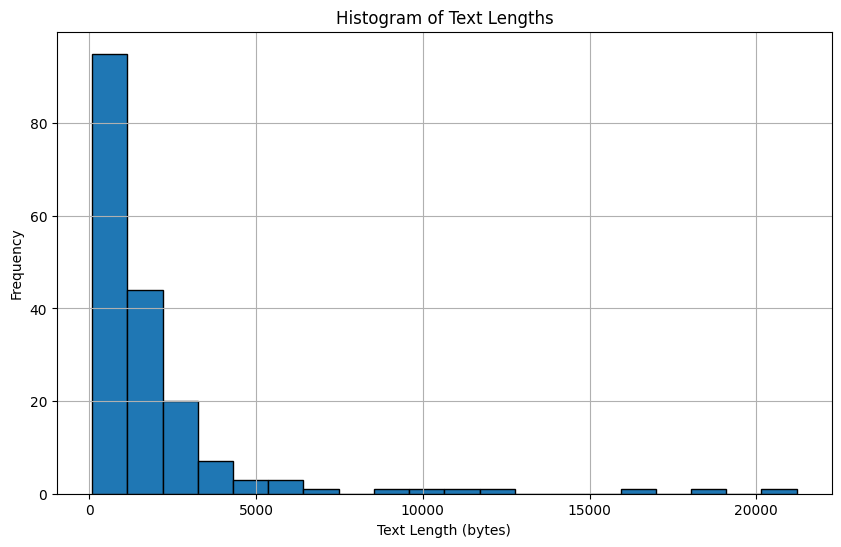

In [14]:
import matplotlib.pyplot as plt

# Create a list to store the text lengths for each split
text_lengths = []
split_lentgh = len(splits)
print(split_lentgh)
for i, doc in enumerate(splits):
    text_length = len(doc.page_content)
    text_lengths.append(text_length)
    if(text_length>40960):
        print(doc.metadata['source'])

# Create a histogram of text lengths
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=20, edgecolor='black')
plt.xlabel('Text Length (bytes)')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths')
plt.grid(True)
plt.show()

In [25]:
splits[11]

Document(page_content='# Amendments to the FASB Accounting Standards Codification ${ }^{\\circledR}$  \n## Introduction  \n1. The Accounting Standards Codification is amended as described in paragraphs $2-41$. In some cases, to put the change in context, not only are the amended paragraphs shown but also the preceding and following paragraphs. Terms from the Master Glossary are in bold type. Added text is underlined, and deleted text is struck out.', metadata={'Header 1': 'Amendments to the FASB Accounting Standards Codification ${ }^{\\circledR}$', 'Header 2': 'Introduction', 'source': '2018-FASB-ASU_2018-12.pdf'})

In [378]:
md_file = "./data/md/GAAP/2005-AAA-DIGB36_PracticNote.md"

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, 
    strip_headers=False,
)
loader = TextLoader(md_file)
loaded_docs = loader.load()
# MD splits
md_header_splits = markdown_splitter.split_text(loaded_docs[0].page_content)
len(md_header_splits)


42